# Example 1: Basic Simulation and Recovery of SCD with NPTFit

In this example we cover how to run a point source Monte Carlo simulation for a user defined template and source-count distribution (SCD) with NPTFit-Sim. In this example we use a uniform template to produce a simulated counts map. The counts map is then run through NPTFit to recover the injected SCD.

The relevant modules are imported.

In [18]:
%load_ext memory_profiler
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import time
sys.path.append('../NPTFit-Sim/')
import ps_mc
import numpy as np
from scipy.misc import factorial
import scipy.integrate as integrate
import healpy as hp
import matplotlib.pyplot as plt

from NPTFit import npll

from NPTFit import nptfit # module for performing scan
from NPTFit import dnds_analysis # module for analysing the output
from NPTFit import psf_correction as pc

from __future__ import print_function

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
n1 = np.array([15.00,-1.0]) # indexes for SCD
S1 = np.array([10.0]) # SCD break, here in terms of counts
A1 = -1.2 # log-normilization

n2 = np.array([17.00,-0.8]) # indexes for SCD
S2 = np.array([20.0]) # SCD break, here in terms of counts
A2 = -1.5 # log-normilization
 
Ebins = np.array([0.5,0.6,0.7,0.85,1.0])
Edep  = lambda E,Eparam: E**Eparam[0]
Eparam1 = np.array([-1.5])
Eparam2 = np.array([-6.])

nside = 4
npix = hp.nside2npix(nside)

temp = 0.1 * np.ones(npix).astype(float)
EXP = np.ones(npix).astype(float)

# Calculate the mean exposure
mean_exp = np.mean(EXP)
                   
# Calculate flux break from counts break and mean exposure
F1 = S1 / mean_exp
A1 = A1 + np.log10(mean_exp)
F2 = S2 / mean_exp
A2 = A2 + np.log10(mean_exp)

# Define parameters that specify the PSF
sigma = 0.00001 * np.pi/180.

# Lambda function to pass user defined PSF
psf_r = lambda r: np.exp(-r**2. / (2.*sigma**2.))

pt_sum_compressed = np.array([0.0])
theta1             = np.array([10**A1,n1[0],n1[1],S1[0],Ebins,Edep,Eparam1])
theta2             = np.array([10**A2,n2[0],n2[1],S2[0],Ebins,Edep,Eparam2])
f_ary             = np.array([1.0])
df_rho_div_f_ary  = np.array([1.0])
npt_compressed    = np.array([[0.1],[0.1],[0.1]])
thetam = np.array([theta1,theta2])

In [20]:
sim_maps1 = ps_mc.run(n1,F1,A1,temp,EXP,psf_r,Ebins,Edep,Eparam1,name="map",save=False)
sim_maps2 = ps_mc.run(n2,F2,A2,temp,EXP,psf_r,Ebins,Edep,Eparam2,name="map",save=False)
sum_map = sim_maps1 + sim_maps2

Number of sources from Poisson draw: 10
Sampling the source count distribution.
Simulating counts map ...
Done simulation.
Number of sources from Poisson draw: 7
Sampling the source count distribution.
Simulating counts map ...
Done simulation.


In [21]:
print('data:',np.asarray(sum_map[:-1]))
nfit = nptfit.NPTF(tag='test')
nfit.load_data(sum_map[:-1],EXP,Ebins)

data: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   2  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0
  13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
   0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1  0  0  0  0  0 11  0  0  2  0  0  0  0  0  9  2  0  2  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
   5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0
   0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  1  0
   0  4  0  0  0  0  0  0  0  0

In [26]:
nfit.add_template(temp, 'examp_np_1', units='PS')
nfit.add_non_poiss_model('examp_np_1', Edep,
                      ['$A_\mathrm{examp1}^\mathrm{ps}$','$n_1^\mathrm{examp1}$','$n_2^\mathrm{examp1}$','$S_b^{(1), \mathrm{examp1}}$','$slope 1$'],
                      [[-3,2.],[2,35],[-2.0,2.0],[0.05,40.0],[-10,-0.1]],
                      [True,False,False,False,False],[False,False,False,False,True])

nfit.add_template(temp, 'examp_np_2', units='PS')
nfit.add_non_poiss_model('examp_np_2', Edep,
                      ['$A_\mathrm{examp2}^\mathrm{ps}$','$n_1^\mathrm{examp2}$','$n_2^\mathrm{examp2}$','$S_b^{(1), \mathrm{examp2}}$','$slope 2$'],
                      [[-3,2.],[2,35],[-2.0,2.0],[0.05,40.0],[-10,-0.1]],
                      [True,False,False,False,False],[False,False,False,False,True])

In [27]:
pc_inst = pc.PSFCorrection(psf_sigma_deg = 0.00001,nside = nside)
f_ary = pc_inst.f_ary
df_rho_div_f_ary = pc_inst.df_rho_div_f_ary
nfit.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Loading the psf correction from: /nfs/turbo/bsafdi/buschman/Fermi/NPTFit-Sim-Edep/examples/psf_dir/gauss_4_0.0_10_50000_1000_0.01.npy
The number of parameters to be fit is 10


In [28]:
start=time.time()
nfit.perform_scan(nlive=20)
end=time.time()
print('runtime: ',end - start)

runtime:  156.425678968


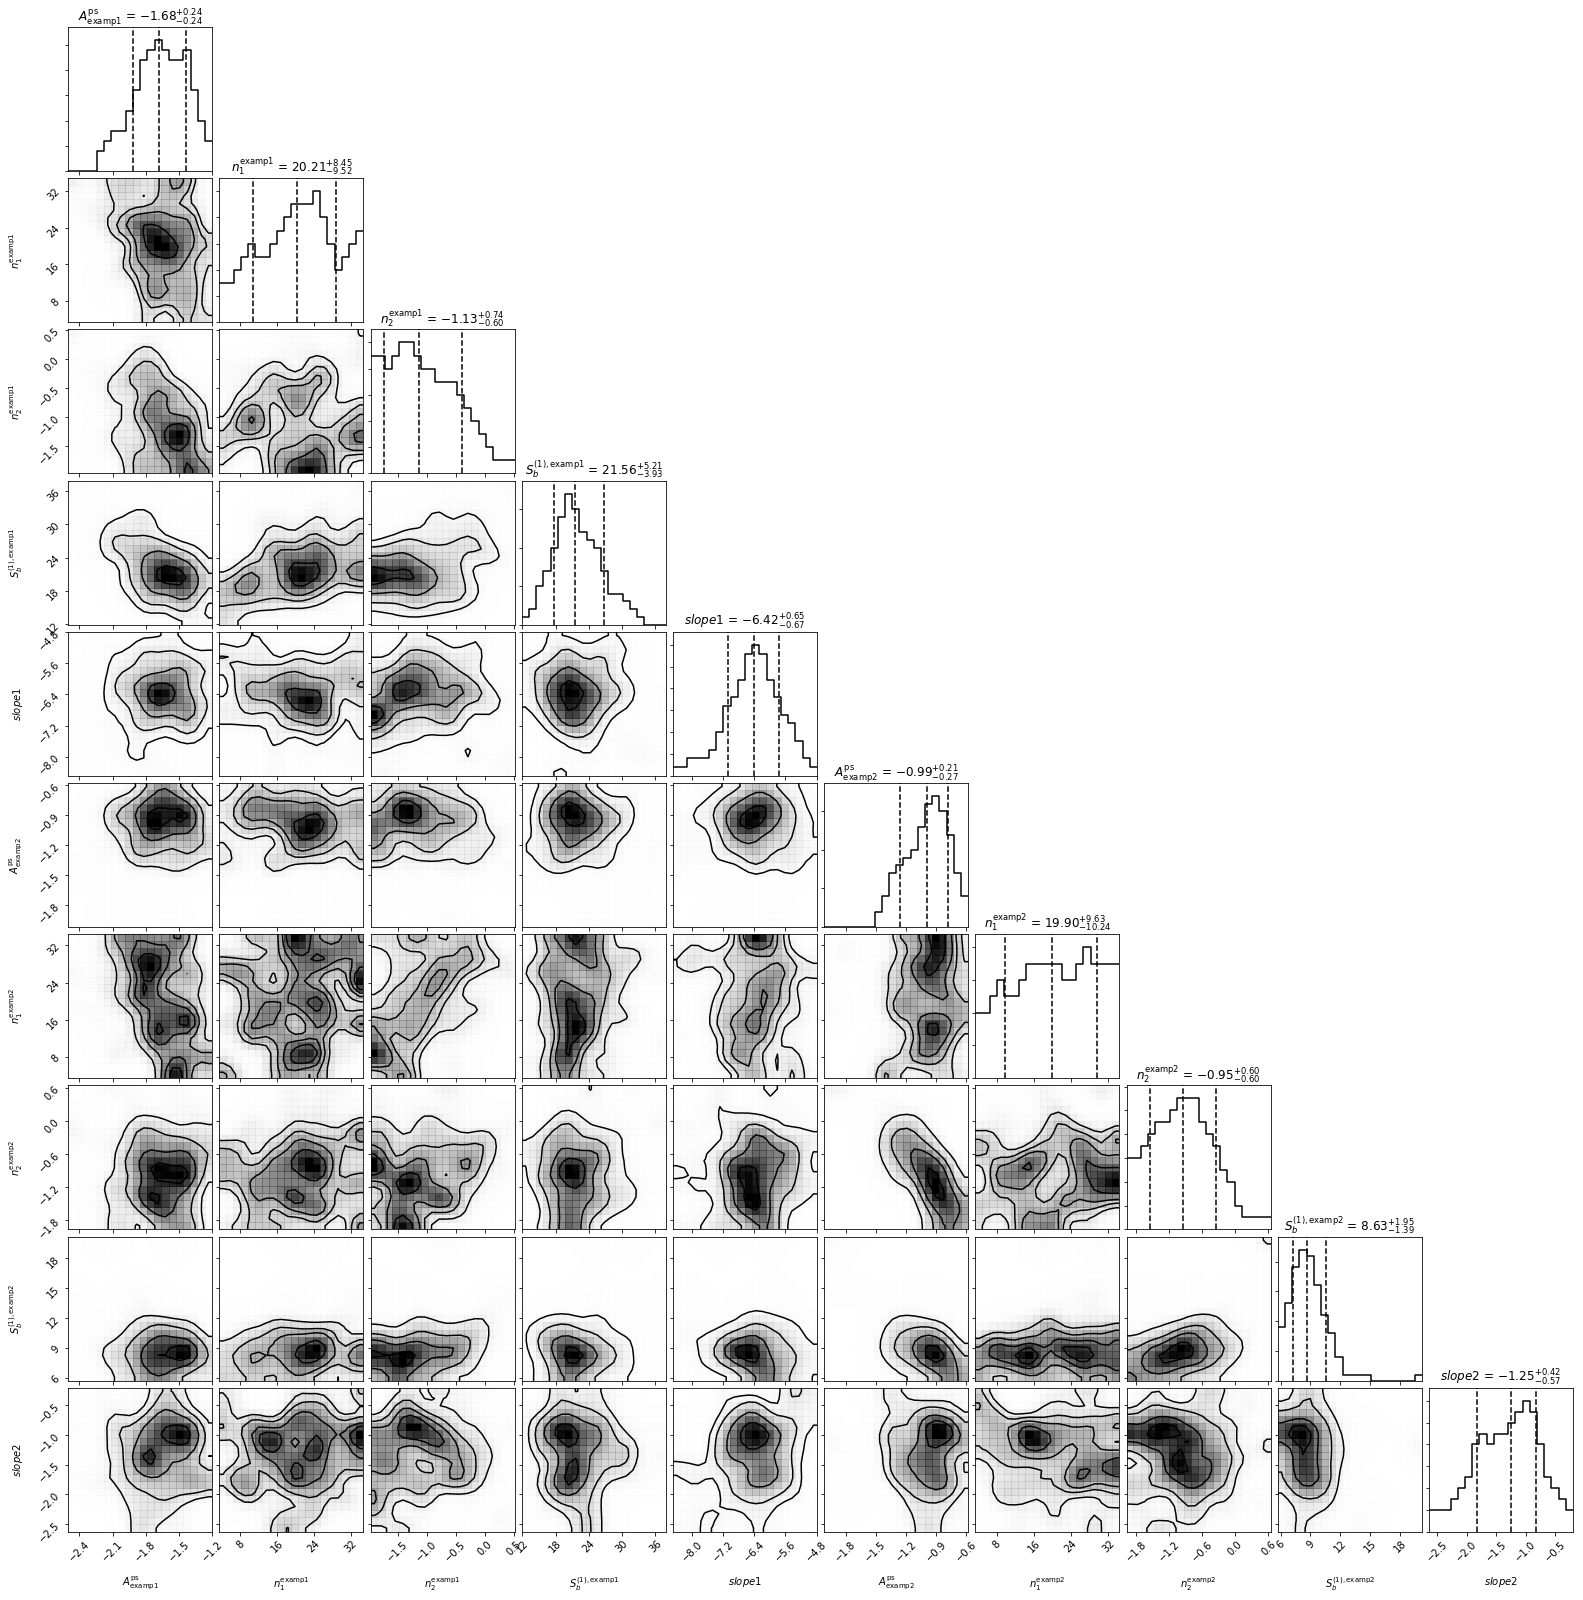

In [29]:
nfit.load_scan()
an = dnds_analysis.Analysis(nfit)
an.make_triangle()